In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, validation_curve
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, PowerTransformer, FunctionTransformer
from sklearn.linear_model import Ridge

In [2]:
df = pd.read_csv(os.path.join("data", "processed", "all_data.csv"))
df.set_index("commune_id", inplace=True)
df.drop(columns=["name"], inplace=True)
vote_share_cols = [col for col in df.columns if col.startswith("vote_share_")]
df.drop(columns=vote_share_cols, inplace=True)

In [3]:
df.shape

(2196, 52)

In [4]:
df_typo = df["typology"] # needed for stratification below
df = pd.get_dummies(df, columns=["language", "canton", "typology"])

df_train, df_test = train_test_split(df, test_size=0.2, random_state=0, stratify=df_typo)
X_train = df_train.drop(columns="po_value").values
y_train = df_train["po_value"].values
X_test = df_test.drop(columns="po_value").values
y_test = df_test["po_value"].values

print("X_train.shape = {}".format(X_train.shape))
print("y_train.shape = {}".format(y_train.shape))
print("X_test.shape = {}".format(X_test.shape))
print("y_test.shape = {}".format(y_test.shape))

X_train.shape = (1756, 87)
y_train.shape = (1756,)
X_test.shape = (440, 87)
y_test.shape = (440,)


In [5]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)
print("Dummy MAE = {:.3f}".format(mean_absolute_error(y_test, dummy.predict(X_test))))

Dummy MAE = 0.315


In [6]:
ridge = Pipeline([
    ('stdscaler', StandardScaler()),
    ('ridge', Ridge())
])
# print(ridge.get_params())
ridge.fit(X_train, y_train)
ridge_test_pred = ridge.predict(X_test)
print("Ridge MAE = {:.3f}".format(mean_absolute_error(y_test, ridge_test_pred)))
print("Ridge R^2 = {:.3f}".format(ridge.score(X_test, y_test)))

Ridge MAE = 0.169
Ridge R^2 = 0.695


In [7]:
parameters = { "ridge__alpha": np.logspace(-4, 4, num = 33) }
gcv = GridSearchCV(ridge, parameters, scoring = "neg_mean_absolute_error", cv = 5, iid = False, n_jobs=12)
gcv.fit(X_train, y_train)
print("Grid search / cross-validation:")
print("Best alpha = {:.2f}".format(gcv.best_params_["ridge__alpha"]))
print("Best MAE = {:.3f}".format(-gcv.best_score_))

Grid search / cross-validation:
Best alpha = 5.62
Best MAE = 0.178


In [8]:
gcv_test_pred = gcv.predict(X_test)
print("On test data:")
print("Tuned Ridge MAE = {:.3f}".format(mean_absolute_error(y_test, gcv_test_pred)))
print("Tuned Ridge R^2 = {:.3f}".format(r2_score(y_test, gcv_test_pred)))

On test data:
Tuned Ridge MAE = 0.169
Tuned Ridge R^2 = 0.698


In [9]:
def validationcurve_plot(name, param_range, train_scores, valid_scores, ax):
    """Plots a validation curve and marks the best test score."""
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)

    sns.set_style('whitegrid')
    sns.lineplot(param_range, train_scores_mean, label="train", ax=ax)
    ax.set_xscale('log')
    ax.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
    sns.lineplot(param_range, valid_scores_mean, label="validation", ax=ax)
    ax.set_xscale('log')
    ax.fill_between(param_range, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.2)
    ax.set_title("Validation curve for " + name)

    best_idx = valid_scores_mean.argmax()
    ax.scatter(param_range[best_idx], valid_scores_mean[best_idx], marker='x', c='red', zorder=10, label="best")

    ax.legend()

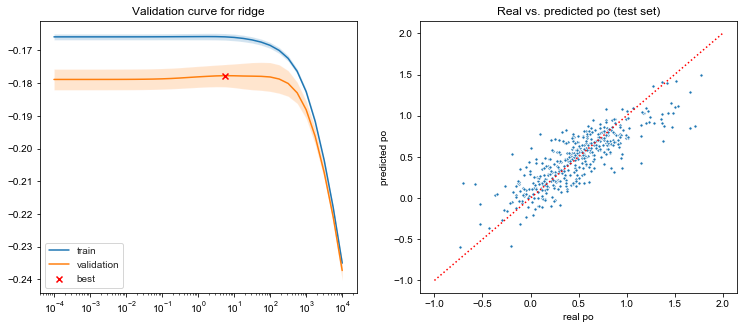

In [10]:
param_range = np.logspace(-4, 4, num = 33)
train_scores, valid_scores = validation_curve(ridge, X_train, y_train, param_name="ridge__alpha",
                                              scoring = "neg_mean_absolute_error", param_range=param_range,
                                              cv=5, n_jobs=12)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.5, 5))

validationcurve_plot("ridge", param_range, train_scores, valid_scores, ax1)

sns.scatterplot(y_test, ridge_test_pred, s=10, ax=ax2)
ax2.set_xlabel("real po")
ax2.set_ylabel("predicted po")
ax2.set_title("Real vs. predicted po (test set)")
ax2.plot([-1, 2], [-1, 2], color="red", linestyle=":")
plt.show()

In [11]:
skewed_features = [
    'residents', 'population_density', 'households', 'employed_total', 'employed_primary_sector',
    'employed_secondary_sector', 'employed_tertiary_sector', 'workplaces_total', 'workplaces_primary_sector',
    'workplaces_secondary_sector', 'workplaces_tertiary_sector', 'new_housing_rate', 'surface_area',
    'agricultural_area_change', 'unproductive_area_percent', 'total_tax_income', 'per_capita_tax_income'
]

unskewed_features = [
    'population_change', 'foreign_nationals_percent', 'age_0_19', 'age_20_64', 'age_65_over',
    'marriage_rate', 'divorce_rate', 'birth_rate', 'mortality_rate', 'households_size',
    'settlement_urban_area_percent', 'settlement_urban_area_change', 'agricultural_area_percent',
    'wooded_area_percent', 'dwelling_vacancy_rate', 'social_assistance_rate',
    'health_region', 'health_premium_child', 'health_premium_young', 'health_premium_adult',
    'rel_share_rk', 'rel_share_ref', 'rel_share_other', 'rel_share_none', 'unemployed',
    'unemployment_rate', 'crime_rate_stgb', 'e_cntr', 'n_cntr', 'z_min'
]
skewed_idxs = [df.columns.get_loc(c) for c in skewed_features]
unskewed_idxs = [df.columns.get_loc(c) for c in unskewed_features]
all_idxs = np.arange(0, X_train.shape[1])

preprocessor = make_column_transformer(
    (PowerTransformer(), skewed_idxs),
    (StandardScaler(), all_idxs),
    remainder = "passthrough"
)

ridge2 = make_pipeline(preprocessor, Ridge())

ridge2.fit(X_train, y_train)
ridge2_test_pred = ridge2.predict(X_test)
print("Ridge2 MAE = {:.3f}".format(mean_absolute_error(y_test, ridge2_test_pred)))
print("Ridge2 R^2 = {:.3f}".format(ridge2.score(X_test, y_test)))

Ridge2 MAE = 0.157
Ridge2 R^2 = 0.744


C:\Users\Joerg\.conda\envs\exts-ml\lib\site-packages\sklearn\preprocessing\data.py:2798: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [12]:
parameters = { "ridge__alpha": np.logspace(-4, 4, num = 33) }
gcv2 = GridSearchCV(ridge2, parameters, scoring = "neg_mean_absolute_error", cv = 5, iid = False, n_jobs=12)
gcv2.fit(X_train, y_train)
print("Grid search / cross-validation:")
print("Best alpha = {:.2f}".format(gcv2.best_params_["ridge__alpha"]))
print("Best MAE = {:.3f}".format(-gcv2.best_score_))

Grid search / cross-validation:
Best alpha = 1.00
Best MAE = 0.167


C:\Users\Joerg\.conda\envs\exts-ml\lib\site-packages\sklearn\preprocessing\data.py:2798: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [13]:
gcv2_test_pred = gcv2.predict(X_test)
print("On test data:")
print("Tuned Ridge2 MAE = {:.3f}".format(mean_absolute_error(y_test, gcv2_test_pred)))
print("Tuned Ridge2 R^2 = {:.3f}".format(r2_score(y_test, gcv2_test_pred)))

On test data:
Tuned Ridge2 MAE = 0.157
Tuned Ridge2 R^2 = 0.744


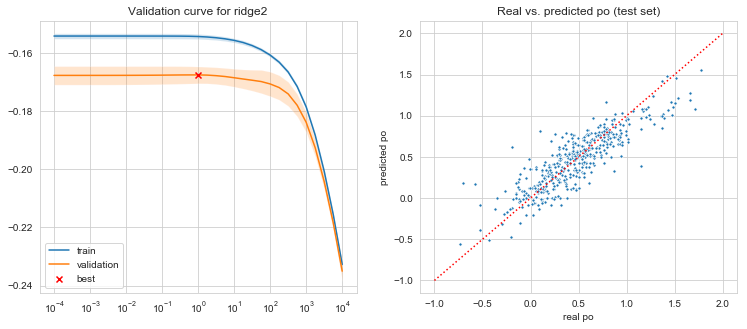

In [14]:
param_range = np.logspace(-4, 4, num = 33)
train_scores, valid_scores = validation_curve(ridge2, X_train, y_train, param_name="ridge__alpha",
                                              scoring = "neg_mean_absolute_error", param_range=param_range,
                                              cv=5, n_jobs=12)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.5, 5))

validationcurve_plot("ridge2", param_range, train_scores, valid_scores, ax1)

sns.scatterplot(y_test, ridge2_test_pred, s=10, ax=ax2)
ax2.set_xlabel("real po")
ax2.set_ylabel("predicted po")
ax2.set_title("Real vs. predicted po (test set)")
ax2.plot([-1, 2], [-1, 2], color="red", linestyle=":")
plt.show()